# Classic DQN

In [ ]:
pip install gym
pip install yfinance
pip install numpy --upgrade #check if numpy is the most recent version

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathSP = "/content/drive/MyDrive/Colab Notebooks/Thesis code/data/SP2014-2016.csv"

In [ ]:
pathMSFT = "/content/drive/MyDrive/Colab Notebooks/Thesis code/data/MSFT2014-2016.csv"

In [ ]:
pathcorrSP = "/content/drive/MyDrive/Colab Notebooks/Thesis code/data/correlation_test_SP.csv"

In [ ]:
pathcorrMSFT = "/content/drive/MyDrive/Colab Notebooks/Thesis code/data/correlation_test_MSFT.csv"

# Trading_env

In [ ]:
import random

class TradingSystem_v0:
    def __init__(self, returns_data, k_value, action_dim, initial_balance,mode,stock):
        self.mode = mode  # test or train
        self.r_ts = returns_data
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.k = k_value
        self.tickers = stock
        self.curr_position = 0
        self.action_space_dim = action_dim
        self.total_steps = returns_data.shape[0] - self.k
        self.core = float(returns_data.iloc[returns_data.shape[0]-1,3])
        self.dev = float(np.std(returns_data.iloc[:,3]))
        self.current_step = 0
        self.initial_state = returns_data.iloc[0,:]
        self.state = self.initial_state
        self.reward = 0.0
        self.trans_cost = 0.0005 # transaction cost
        self.slippage_rate = 0.001 # slippage rate
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
            self.is_terminal = True

        self.pos_change = action - self.action_space_dim//2  # get action(position) of the actor

        self.curr_position = self.curr_position + self.pos_change

        if self.pos_change == 0:

            close_price = self.r_ts.iloc[self.current_step,3]
            close_price_bf = self.r_ts.iloc[self.current_step-1,3]
            self.reward = self.pos_change * (close_price - close_price_bf)

        else:
            close_price = self.r_ts.iloc[self.current_step,3]
            close_price_bf = self.r_ts.iloc[self.current_step-1,3]
            self.reward = self.pos_change * (close_price - close_price_bf)  - abs(self.pos_change)* (self.trans_cost+self.slippage_rate)


        self.state = self.r_ts.iloc[self.current_step+1,:]

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.r_ts = self.r_ts
        self.total_steps = len(self.r_ts) - self.k
        self.balance = self.initial_balance
        self.current_step = 0
        self.initial_state = self.r_ts.iloc[0,:]
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state



# dqn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np


class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)  # input layer
        self.fc2 = nn.Linear(64, hidden_dim)  # hidden layer 1
        self.fc3 = nn.Linear(hidden_dim, 128)  # hidden layer 2
        self.fc4 = nn.Linear(128, action_dim) # output layer

    def forward(self, x):
        # activation function
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))

        return self.fc4(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity  # capacity of buffer
        self.buffer = []  # replay buffer
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        ''' replay buffer is a queue (LIFO)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


class DQN:
    def __init__(self, state_dim, action_dim, cfg):

        self.action_dim = action_dim
        self.device = cfg.device  # cpu or gpu
        self.gamma = cfg.gamma  # discount factor
        self.frame_idx = 0  # attenuation
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
                                         (cfg.epsilon_start - cfg.epsilon_end) * \
                                         math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim, hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),
                                       self.policy_net.parameters()):  # copy parameters to target net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # optimizer
        self.memory = ReplayBuffer(cfg.memory_capacity)  # experience replay

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)   # received observation
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()  # choose the action with maximum q-value
        else:
            action = random.randrange(self.action_dim)
        return action

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # transfer to tensor
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        # calculate the expected q-value, for final state, done_batch[0]=1 and the corresponding
        # expected_q_value equals to reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        # update the network
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():  # avoid gradient explosion by using clip
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, path):
        torch.save(self.target_net.state_dict(), path + 'dqn_checkpoint.pth')

    def load(self, path):
        self.target_net.load_state_dict(torch.load(path + 'dqn_checkpoint.pth'))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# Main

In [ ]:
import sys
import os
import os.path


curr_path = os.path.abspath('')

import gym
import torch
import numpy as np
import random
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

curr_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
random.seed(11)



class Config:
    '''
    hyperparameters
    '''

    def __init__(self):
        ################################## env hyperparameters ###################################
        self.algo_name = 'DQN' # algorithmic name
        self.env_name = 'TradingSystem_v0' # environment name
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # examine GPU
        self.seed = 11 # random seed
        self.train_eps = 100 # number of training episode
        self.state_space_dim = 8 # state space size (K-value)
        self.initial_balance = 1000000
        self.action_space_dim = 3 # action space size (only odd number can be applied)
        ################################################################################

        ################################## algo hyperparameters ###################################
        self.gamma = 0.95  # discount factor
        self.epsilon_start = 0.90  # start epsilon of e-greedy policy
        self.epsilon_end = 0.01  # end epsilon of e-greedy policy
        self.epsilon_decay = 500  # attenuation rate of epsilon in e-greedy policy
        self.lr = 0.0001  # learning rate
        self.memory_capacity = 1000  # capacity of experience replay
        self.batch_size = 64  # size of mini-batch SGD
        self.target_update = 4  # update frequency of target network
        self.hidden_dim = 128  # dimension of hidden layer
        ################################################################################

        ################################# save path ##############################
        self.result_path = curr_path + "/outputs/" + self.env_name + \
                           '/' + curr_time + '/results/'
        self.model_path = curr_path + "/outputs/" + self.env_name + \
                          '/' + curr_time + '/models/'
        self.save = True  # whether to save the image
        ################################################################################


def env_agent_config(data, cfg, mode,stock):
    ''' create environment and agent
    '''
    env = TradingSystem_v0(data, cfg.state_space_dim, cfg.action_space_dim, cfg.initial_balance, mode, stock)
    agent = DQN(cfg.state_space_dim, cfg.action_space_dim, cfg)

    if cfg.seed != 0:  # set random seeds
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)
    return env, agent


def train(cfg, env, agent):
    ''' training
    '''
    print('Start Training!')
    print(f'Environment：{cfg.env_name}, Algorithm：{cfg.algo_name}, Device：{cfg.device}, Stock: {env.tickers}')
    rewards = []  # record total rewards
    ma_rewards = []  # record moving average total rewards
    stocks = env.tickers
    ep_reward = 0
    state = env.reset()
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset()
        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)  # save transition
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:  # update target network
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print('Episode：{}/{}, Reward：{}'.format(i_ep + 1, cfg.train_eps, ep_reward))
    print('Finish Training!')
    return rewards, ma_rewards


def test(cfg, env, agent):
    print('Start Testing!')
    print(f'Environment：{cfg.env_name}, Algorithm：{cfg.algo_name}, Device：{cfg.device},Stock: {env.tickers}')
    ############# Test does not use e-greedy policy, so we set epsilon to 0 ###############
    cfg.epsilon_start = 0.0
    cfg.epsilon_end = 0.0
    ################################################################################
    stocks = env.tickers
    returns = []  # record total rewards
    ep_reward = 0
    state = env.reset()
    while True:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        state = next_state
        ep_reward += reward
        if done:
            break

    returns.append(ep_reward)
    print(f"Stock：{stocks}，Return：{ep_reward:.1f}")
    print('Finish Testing!')
    return stocks, ep_reward


# Running files

# Indicators

In [ ]:
def MA(sorted_data, period):
	ma_list = []
	for i in range(len(sorted_data)):
		if(i < period - 1):
			ma_list.append(sorted_data[i])
			#ma_list.append(None)
		else:
			ma_sum = 0.0
			for j in range(i, i - period, -1):
				ma_sum += sorted_data[j]
			curr_ma = ma_sum / period
			ma_list.append(curr_ma)
	return ma_list

def EMA(data, period):
    sorted_data = np.array([data[i] for i in sorted(data.keys())])
    sma = np.mean(sorted_data[:period])
    ema_list = []
    smooth_weighting = 2.0 / (period + 1)
    for i in range(len(sorted_data)):
        if i < period - 1:
            ema_list.append(sma)
        else:
            new_ema = (sorted_data[i] - ema_list[-1]) * smooth_weighting + ema_list[-1]
            ema_list.append(new_ema)
    assert len(ema_list) == len(sorted_data)
    return np.array(ema_list)

def MACD(sorted_data, period_1, period_2):
	period_1_ema_list = EMA(sorted_data, period_1)
	period_2_ema_list = EMA(sorted_data, period_2)
	assert len(period_1_ema_list) == len(period_2_ema_list)
	macd_list = period_1_ema_list - period_2_ema_list
	return macd_list


def ROC(data, period):
    roc_list = []
    for i in range(len(data)):
        if i == 0:
            roc_list.append(0.0)
        elif i < period:
            curr_roc = (data[i] - data[0]) / data[0]
            roc_list.append(curr_roc)
        else:
            curr_roc = (data[i] - data[i - period]) / data[i - period]
            roc_list.append(curr_roc)
    return roc_list

def SR(sorted_data, period, risk_free_rate=0.007):
    # trading hours per day
    risk_free_rate = risk_free_rate / (6.5 * 60)
    sr_list = []
    for i in range(len(sorted_data)):
        if i < period:
            sr_list.append(0.0)
        else:
            expected_return_list = []
            for j in range(i, i - period, -1):
                perc_change = (sorted_data[j] - sorted_data[j - 1]) / sorted_data[j - 1]
                expected_return_list.append(perc_change)
            expected_return_list = np.array(expected_return_list)
            std = np.std(expected_return_list)
            if std != 0.0:
                sr_list.append((np.mean(expected_return_list) - risk_free_rate) / std)
            else:
                sr_list.append(0.0)
    return sr_list


# Uploading Dataset

In [ ]:
import pandas as pd
from sklearn import preprocessing
import math

### S&P 500 ###
# SP = pd.read_csv(r'/Users/gilseyeon/Downloads/data/SPXUSD/SP2012.csv')

SP = pd.read_csv(pathSP)
oo = range(0,len(SP),30)
returns_SP = SP.iloc[oo,].reset_index(drop=True)

returns_SP = returns_SP.iloc[:,2:6] # remove time stamps


# add financial indicators
returns_SP = returns_SP.assign(MA = MA(returns_SP.iloc[:,3],10), MACD = MACD(returns_SP.iloc[:,3],10,20)
,ROC = ROC(returns_SP.iloc[:,3],10), SR = SR(returns_SP.iloc[:,3],10))

#splitting train and test set
splitter = math.ceil(returns_SP.shape[0]*0.9)
SP_train = returns_SP.iloc[0:splitter,:]
SP_test = returns_SP.iloc[splitter+1:,:].reset_index(drop=True)



### Microsoft ###
MSFT = pd.read_csv(pathMSFT)
dd = range(0,len(MSFT),6)
returns_MSFT = MSFT.iloc[dd,].reset_index(drop=True)


returns_MSFT = returns_MSFT.iloc[:,1:5] # remove time stamps


# add financial indicators
returns_MSFT = returns_MSFT.assign(MA = MA(returns_MSFT.iloc[:,3],10), MACD = MACD(returns_MSFT.iloc[:,3],10,20)
,ROC = ROC(returns_MSFT.iloc[:,3],10), SR = SR(returns_MSFT.iloc[:,3],10))

#splitting train and test set
splitter = math.ceil(returns_MSFT.shape[0]*0.9)
MSFT_train = returns_MSFT.iloc[0:splitter,:]
MSFT_test = returns_MSFT.iloc[splitter+1:,:].reset_index(drop=True)

In [ ]:
#Training SP500
cfg = Config()
env, agent = env_agent_config(SP_train, cfg, 'train','SP500')
rewards_train_SP, ma_rewards_train_SP = train(cfg, env, agent)

Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda, Stock: SP500
Episode：10/100, Reward：14383.05899999805
Episode：20/100, Reward：14506.867999998134
Episode：30/100, Reward：14000.667499998173
Episode：40/100, Reward：14343.419999998137
Episode：50/100, Reward：13645.988999998188
Episode：60/100, Reward：14177.441999998115
Episode：70/100, Reward：14258.802499998235
Episode：80/100, Reward：13874.561499998406
Episode：90/100, Reward：14358.23399999834
Episode：100/100, Reward：14455.988999998328
Finish Training!


In [ ]:
rewards_train_SP

[6341.244999999335,
 10296.791499998628,
 12453.976499998174,
 12687.344499998007,
 13778.956999998007,
 13917.007499997946,
 14138.128499997976,
 13781.370999998024,
 14070.203999998066,
 14383.05899999805,
 14521.251999998043,
 14580.534499998064,
 14371.875499997934,
 14231.295499998057,
 14547.355999998032,
 14750.62849999807,
 14395.681999998102,
 14354.754499998053,
 14419.35149999803,
 14506.867999998134,
 14516.901999998034,
 14167.8299999981,
 14238.6594999981,
 14320.409999998092,
 14265.891499998024,
 14272.861499998111,
 14729.950499998087,
 14383.367999998141,
 14128.286999998134,
 14000.667499998173,
 14329.90349999817,
 14568.779499998158,
 14607.108999998138,
 14545.051499998073,
 14273.719999998144,
 14622.548499998067,
 14695.199499998052,
 14437.29749999814,
 14692.63399999806,
 14343.419999998137,
 14556.183999998028,
 14394.008499998125,
 14429.187999998137,
 14074.102999998215,
 14296.567999998108,
 14337.442499998126,
 14464.504499998156,
 14208.998999998195,
 13

In [ ]:
ma_rewards_train_SP

[6341.244999999335,
 6736.799649999264,
 7308.517334999155,
 7846.40005149904,
 8439.655746348937,
 8987.390921713839,
 9502.464679542252,
 9930.355311587831,
 10344.340180428855,
 10748.212062385775,
 11125.516056147002,
 11471.017900532108,
 11761.103660478691,
 12008.122844430629,
 12262.04615998737,
 12510.904393988441,
 12699.382154589408,
 12864.919389130273,
 13020.36260021705,
 13169.013140195158,
 13303.802026175446,
 13390.204823557713,
 13475.050291201753,
 13559.586262081386,
 13630.21678587305,
 13694.481257285555,
 13798.028181556809,
 13856.562163400942,
 13883.73464706066,
 13895.427932354412,
 13938.87548911879,
 14001.865890206727,
 14062.39020118587,
 14110.656331067092,
 14126.962697960196,
 14176.521278163984,
 14228.389100347391,
 14249.279940312466,
 14293.615346281025,
 14298.595811652736,
 14324.354630487265,
 14331.320017438351,
 14341.10681569433,
 14314.406434124718,
 14312.622590712057,
 14315.104581640664,
 14330.044573476414,
 14317.940016128594,
 14239.8

In [ ]:
# Testing SP500
cfg = Config()
env, agent = env_agent_config(SP_test, cfg, 'test',"SP500")
stocks_test_SP, rewards_test_SP = test(cfg, env, agent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Start Testing!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda,Stock: SP500
Stock：SP500，Return：129.8
Finish Testing!


In [ ]:
rewards_test_SP

129.77600000000297

In [ ]:
# Training Microsoft
cfg = Config()
env, agent = env_agent_config(MSFT_train, cfg, 'train','MSFT')
rewards_train_MSFT, ma_rewards_train_MSFT = train(cfg, env, agent)

Start Training!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda, Stock: MSFT
Episode：10/100, Reward：719.7910000000331
Episode：20/100, Reward：737.321800000036
Episode：30/100, Reward：709.0261000000362
Episode：40/100, Reward：737.5807000000364
Episode：50/100, Reward：736.7670000000346
Episode：60/100, Reward：749.6939000000351
Episode：70/100, Reward：740.3302000000349
Episode：80/100, Reward：739.2521000000338
Episode：90/100, Reward：751.3556000000351
Episode：100/100, Reward：743.0103000000345
Finish Training!


In [ ]:
rewards_train_MSFT

[506.6888000000299,
 648.1050000000345,
 667.7368000000376,
 670.3935000000356,
 705.1052000000341,
 707.7218000000329,
 709.4707000000338,
 720.9312000000341,
 713.9753000000329,
 719.7910000000331,
 726.1011000000364,
 727.4617000000355,
 737.5222000000346,
 736.033000000034,
 726.2415000000328,
 732.0669000000347,
 733.5614000000342,
 730.4773000000348,
 742.7232000000346,
 737.321800000036,
 719.6831000000351,
 703.9708000000342,
 716.9664000000355,
 716.7663000000355,
 711.3895000000363,
 714.0383000000351,
 711.4087000000338,
 713.0548000000341,
 705.614300000036,
 709.0261000000362,
 716.220500000035,
 716.908900000035,
 701.1281000000346,
 721.1504000000351,
 719.564800000036,
 719.209000000035,
 732.9220000000344,
 738.0564000000347,
 730.4756000000352,
 737.5807000000364,
 725.0204000000346,
 740.4960000000373,
 748.3492000000341,
 735.3170000000359,
 736.1922000000357,
 753.0931000000335,
 740.9702000000343,
 748.6216000000336,
 742.1881000000353,
 736.7670000000346,
 750.31

In [ ]:
ma_rewards_train_MSFT

[506.6888000000299,
 520.8304200000304,
 535.5210580000311,
 549.0083022000315,
 564.6179919800318,
 578.9283727820318,
 591.982605503832,
 604.8774649534522,
 615.7872484581103,
 626.1876236123026,
 636.178971251076,
 645.3072441259719,
 654.5287397133783,
 662.6791657420439,
 669.0353991678428,
 675.3385492510621,
 681.1608343259593,
 686.0924808933669,
 691.7555528040336,
 696.3121775236339,
 698.649269771274,
 699.18142279415,
 700.9599205147385,
 702.5405584632683,
 703.4254526169452,
 704.4867373552543,
 705.1789336197322,
 705.9665202577625,
 705.9312982319898,
 706.2407784087944,
 707.2387505679185,
 708.2057655111302,
 707.4979989600206,
 708.8632390640221,
 709.9333951576235,
 710.8609556418646,
 713.0670600776816,
 715.5659940699169,
 717.0569546629287,
 719.1093291966395,
 719.7004362769791,
 721.7799926492848,
 724.4369133843599,
 725.5249220459275,
 726.5916498413384,
 729.241794857208,
 730.4146353714907,
 732.235331834345,
 733.230608650914,
 733.584247785826,
 735.2572

In [ ]:
# Testing Microsoft
env, agent = env_agent_config(MSFT_test, cfg, 'test',"MSFT")
stocks_test_MSFT, rewards_test_MSFT= test(cfg, env, agent)

Start Testing!
Environment：TradingSystem_v0, Algorithm：DQN, Device：cuda,Stock: MSFT
Stock：MSFT，Return：32.5
Finish Testing!


In [ ]:
rewards_test_MSFT

32.495198636342

# Combine the results

In [ ]:
corr_SP = pd.read_csv(pathcorrSP)
corr_MSFT = pd.read_csv(pathcorrMSFT)

## Classic DQN

In [ ]:
rewards_train_SP_XX = [6341.244999999335,
 10296.791499998628,
 12453.976499998174,
 12687.344499998007,
 13778.956999998007,
 13917.007499997946,
 14138.128499997976,
 13781.370999998024,
 14070.203999998066,
 14383.05899999805,
 14521.251999998043,
 14580.534499998064,
 14371.875499997934,
 14231.295499998057,
 14547.355999998032,
 14750.62849999807,
 14395.681999998102,
 14354.754499998053,
 14419.35149999803,
 14506.867999998134,
 14516.901999998034,
 14167.8299999981,
 14238.6594999981,
 14320.409999998092,
 14265.891499998024,
 14272.861499998111,
 14729.950499998087,
 14383.367999998141,
 14128.286999998134,
 14000.667499998173,
 14329.90349999817,
 14568.779499998158,
 14607.108999998138,
 14545.051499998073,
 14273.719999998144,
 14622.548499998067,
 14695.199499998052,
 14437.29749999814,
 14692.63399999806,
 14343.419999998137,
 14556.183999998028,
 14394.008499998125,
 14429.187999998137,
 14074.102999998215,
 14296.567999998108,
 14337.442499998126,
 14464.504499998156,
 14208.998999998195,
 13536.915499998257,
 13645.988999998188,
 14001.367499998114,
 14129.646499998045,
 14111.149499998177,
 14339.037999998076,
 14445.661999998107,
 14535.806499998127,
 14624.735999998024,
 14446.292499998075,
 14400.654499998089,
 14177.441999998115,
 14403.635499998076,
 14540.065999998234,
 14729.596999998164,
 14886.078499998144,
 14551.427499998183,
 14672.307999998184,
 14719.122499998213,
 14783.518999998161,
 14429.298999998218,
 14258.802499998235,
 14056.474999998338,
 13739.038499998316,
 13678.366499998354,
 13940.65349999833,
 13827.477999998368,
 14048.568999998324,
 13982.810999998374,
 13810.356999998394,
 13639.000499998387,
 13874.561499998406,
 13806.903499998398,
 13933.65049999835,
 13844.363999998359,
 14002.289999998335,
 14471.026999998248,
 14493.325999998298,
 14104.592999998344,
 14241.860999998275,
 14267.733999998381,
 14358.23399999834,
 14441.651999998365,
 14724.459499998336,
 14709.99349999826,
 14538.040499998324,
 14622.459999998344,
 14618.736499998298,
 14562.679499998278,
 14036.192499998366,
 14249.05549999826,
 14455.988999998328]

ma_rewards_train_SP_XX = [6341.244999999335,
 6736.799649999264,
 7308.517334999155,
 7846.40005149904,
 8439.655746348937,
 8987.390921713839,
 9502.464679542252,
 9930.355311587831,
 10344.340180428855,
 10748.212062385775,
 11125.516056147002,
 11471.017900532108,
 11761.103660478691,
 12008.122844430629,
 12262.04615998737,
 12510.904393988441,
 12699.382154589408,
 12864.919389130273,
 13020.36260021705,
 13169.013140195158,
 13303.802026175446,
 13390.204823557713,
 13475.050291201753,
 13559.586262081386,
 13630.21678587305,
 13694.481257285555,
 13798.028181556809,
 13856.562163400942,
 13883.73464706066,
 13895.427932354412,
 13938.87548911879,
 14001.865890206727,
 14062.39020118587,
 14110.656331067092,
 14126.962697960196,
 14176.521278163984,
 14228.389100347391,
 14249.279940312466,
 14293.615346281025,
 14298.595811652736,
 14324.354630487265,
 14331.320017438351,
 14341.10681569433,
 14314.406434124718,
 14312.622590712057,
 14315.104581640664,
 14330.044573476414,
 14317.940016128594,
 14239.837564515561,
 14180.452708063824,
 14162.544187257252,
 14159.254418531333,
 14154.443926678017,
 14172.903334010023,
 14200.17920060883,
 14233.74193054776,
 14272.841337492788,
 14290.186453743316,
 14301.233258368793,
 14288.854132531726,
 14300.33226927836,
 14324.30564235035,
 14364.834778115131,
 14416.959150303433,
 14430.40598527291,
 14454.596186745439,
 14481.048818070716,
 14511.29583626346,
 14503.096152636936,
 14478.666787373066,
 14436.447608635593,
 14366.706697771866,
 14297.872677994515,
 14262.150760194898,
 14218.683484175246,
 14201.672035757554,
 14179.785932181636,
 14142.84303896331,
 14092.458785066818,
 14070.669056559978,
 14044.292500903819,
 14033.228300813273,
 14014.341870731783,
 14013.136683658438,
 14058.92571529242,
 14102.365743763008,
 14102.588469386543,
 14116.515722447717,
 14131.637550202784,
 14154.29719518234,
 14183.032675663944,
 14237.175358097384,
 14284.457172287472,
 14309.815505058556,
 14341.079954552533,
 14368.84560909711,
 14388.228998187227,
 14353.025348368341,
 14342.628363531334,
 14353.964427178034]

rewards_test_SP_XX = 129.77600000000297

In [ ]:
rewards_train_MSFT_XX = [506.6888000000299,
 648.1050000000345,
 667.7368000000376,
 670.3935000000356,
 705.1052000000341,
 707.7218000000329,
 709.4707000000338,
 720.9312000000341,
 713.9753000000329,
 719.7910000000331,
 726.1011000000364,
 727.4617000000355,
 737.5222000000346,
 736.033000000034,
 726.2415000000328,
 732.0669000000347,
 733.5614000000342,
 730.4773000000348,
 742.7232000000346,
 737.321800000036,
 719.6831000000351,
 703.9708000000342,
 716.9664000000355,
 716.7663000000355,
 711.3895000000363,
 714.0383000000351,
 711.4087000000338,
 713.0548000000341,
 705.614300000036,
 709.0261000000362,
 716.220500000035,
 716.908900000035,
 701.1281000000346,
 721.1504000000351,
 719.564800000036,
 719.209000000035,
 732.9220000000344,
 738.0564000000347,
 730.4756000000352,
 737.5807000000364,
 725.0204000000346,
 740.4960000000373,
 748.3492000000341,
 735.3170000000359,
 736.1922000000357,
 753.0931000000335,
 740.9702000000343,
 748.6216000000336,
 742.1881000000353,
 736.7670000000346,
 750.314500000036,
 758.8273000000368,
 736.431400000035,
 745.1810000000336,
 752.3924000000329,
 742.0045000000337,
 749.6819000000344,
 747.5388000000345,
 752.3856000000341,
 749.6939000000351,
 746.6408000000353,
 753.5362000000332,
 745.2120000000343,
 749.2602000000345,
 758.1085000000348,
 739.898200000034,
 732.2344000000348,
 744.090700000034,
 739.6604000000359,
 740.3302000000349,
 742.0934000000354,
 734.3598000000342,
 744.7587000000347,
 730.1742000000344,
 753.7061000000344,
 735.9633000000335,
 724.0790000000335,
 717.7922000000339,
 734.3374000000334,
 739.2521000000338,
 762.7006000000348,
 737.7985000000352,
 742.5478000000336,
 745.4668000000339,
 747.3808000000341,
 746.613600000036,
 737.1173000000338,
 753.3668000000353,
 742.4632000000355,
 751.3556000000351,
 753.2802000000354,
 764.450400000036,
 742.4149000000351,
 738.184600000035,
 746.8121000000347,
 740.2848000000338,
 741.9821000000356,
 744.7427000000349,
 729.0638000000348,
 743.0103000000345]

ma_rewards_train_MSFT_XX = [506.6888000000299,
 520.8304200000304,
 535.5210580000311,
 549.0083022000315,
 564.6179919800318,
 578.9283727820318,
 591.982605503832,
 604.8774649534522,
 615.7872484581103,
 626.1876236123026,
 636.178971251076,
 645.3072441259719,
 654.5287397133783,
 662.6791657420439,
 669.0353991678428,
 675.3385492510621,
 681.1608343259593,
 686.0924808933669,
 691.7555528040336,
 696.3121775236339,
 698.649269771274,
 699.18142279415,
 700.9599205147385,
 702.5405584632683,
 703.4254526169452,
 704.4867373552543,
 705.1789336197322,
 705.9665202577625,
 705.9312982319898,
 706.2407784087944,
 707.2387505679185,
 708.2057655111302,
 707.4979989600206,
 708.8632390640221,
 709.9333951576235,
 710.8609556418646,
 713.0670600776816,
 715.5659940699169,
 717.0569546629287,
 719.1093291966395,
 719.7004362769791,
 721.7799926492848,
 724.4369133843599,
 725.5249220459275,
 726.5916498413384,
 729.241794857208,
 730.4146353714907,
 732.235331834345,
 733.230608650914,
 733.584247785826,
 735.257273007247,
 737.614275706526,
 737.4959881358769,
 738.2644893222925,
 739.6772803900666,
 739.9100023510633,
 740.8871921159605,
 741.5523529043678,
 742.6356776139345,
 743.3414998525445,
 743.6714298672937,
 744.6579068805676,
 744.7133161925143,
 745.1680045732663,
 746.4620541159431,
 745.8056687043522,
 744.4485418339206,
 744.4127576505318,
 743.9375218854822,
 743.5767896969375,
 743.4284507272472,
 742.5215856545259,
 742.7452970890769,
 741.4881873801726,
 742.7099786421588,
 742.0353107779464,
 740.2396797001551,
 737.994931730143,
 737.629178557132,
 737.7914707014222,
 740.2823836312834,
 740.0339952681586,
 740.2853757413461,
 740.8035181672149,
 741.4612463504968,
 741.9764817154507,
 741.490563543909,
 742.6781871895217,
 742.656688470573,
 743.5265796235192,
 744.5019416611708,
 746.4967874950573,
 746.0885987455551,
 745.2981988710031,
 745.4495889839063,
 744.933110085519,
 744.6380090769707,
 744.648478169277,
 743.0900103523529,
 743.0820393171211]

rewards_test_MSFT_XX = 32.495198636342

## DRQN

In [ ]:
rewards_train_SP_X = [1310.8527648273762,
 17051.445476931276,
 20353.5016751403,
 20564.11394795461,
 21971.272169949025,
 21481.5525654397,
 21419.894563519505,
 21921.402444894233,
 20815.782025852608,
 21726.97176509192,
 24726.125776451696,
 22649.24030157046,
 23308.680099877987,
 23452.313273575906,
 23303.550016427307,
 23506.71275316695,
 23404.35368597615,
 23713.80709854263,
 23203.674127928047,
 25033.448567125466,
 22645.911204863103,
 24934.418596642012,
 25124.180900504216,
 23149.00177155771,
 23767.822367628432,
 24318.244905330434,
 22955.553448160856,
 24059.563894204657,
 22137.936143819155,
 23098.21736353873,
 25637.995524624992,
 25341.04423457853,
 23917.07680297976,
 23048.116238975086,
 23651.81946147305,
 24165.197482746946,
 25434.30340693352,
 24366.886684878427,
 25180.902015733467,
 26452.34049062942,
 25033.57081592259,
 24622.975366600942,
 24571.004490345593,
 23969.375131370252,
 24676.50164049825,
 25590.62425936139,
 25236.147413340324,
 25993.82583947135,
 24677.12925709062,
 25129.777057493924,
 24213.184358024646,
 25639.308607686937,
 25235.055906223148,
 26105.026114311197,
 24018.726390544398,
 24169.890963350772,
 24727.326434280574,
 26036.40975451906,
 25688.849789099484,
 25438.955410266884,
 24983.415116003085,
 25181.147604834834,
 24165.08833203524,
 24524.381998964367,
 23760.045379418618,
 26048.170743706527,
 25540.00466891709,
 25643.61896929263,
 26047.513656421997,
 24978.65396195801,
 24668.560926220867,
 24977.60065758995,
 25235.001330867293,
 25237.268391149642,
 25953.206637234525,
 24780.334242297227,
 26354.920493143796,
 24574.6610391881,
 24935.23722697989,
 25235.001330867293,
 25839.523183703124,
 25532.9917356893,
 24264.88454051494,
 25083.67303199334,
 25290.219440796205,
 25590.638448953905,
 25229.32549385803,
 24726.480516264775,
 24980.331608397093,
 24016.024910429416,
 24980.549909820525,
 25378.989244378292,
 24734.039203051147,
 24369.288000536188,
 25693.10666685643,
 25389.085685212085,
 25835.921210216482,
 26710.73443538339,
 24415.883204239497,
 25236.06555030652]

ma_rewards_train_SP_X = [1310.8527648273762,
 2884.9120360377665,
 4631.77099994802,
 6225.005294748679,
 7799.631982268714,
 9167.824040585812,
 10393.031092879182,
 11545.868228080688,
 12472.85960785788,
 13398.270823581282,
 14531.056318868325,
 15342.874717138538,
 16139.455255412484,
 16870.741057228825,
 17514.021953148673,
 18113.2910331505,
 18642.39729843307,
 19149.538278444026,
 19554.95186339243,
 20102.801533765734,
 20357.11250087547,
 20814.843110452126,
 21245.776889457335,
 21436.09937766737,
 21669.271676663477,
 21934.16899953017,
 22036.307444393242,
 22238.633089374383,
 22228.563394818862,
 22315.52879169085,
 22647.775464984265,
 22917.10234194369,
 23017.099788047297,
 23020.201433140075,
 23083.363235973375,
 23191.546660650733,
 23415.822335279016,
 23510.928770238956,
 23677.92609478841,
 23955.36753437251,
 24063.18786252752,
 24119.166612934863,
 24164.350400675936,
 24144.852873745367,
 24198.017750420655,
 24337.27840131473,
 24427.16530251729,
 24583.831356212697,
 24593.16114630049,
 24646.822737419832,
 24603.458899480313,
 24707.043870300975,
 24759.845073893193,
 24894.363177934993,
 24806.799499195935,
 24743.10864561142,
 24741.530424478336,
 24871.01835748241,
 24952.80150064412,
 25001.416891606397,
 24999.616714046068,
 25017.769803124946,
 24932.501656015975,
 24891.689690310817,
 24778.5252592216,
 24905.489807670092,
 24968.941293794793,
 25036.409061344577,
 25137.519520852322,
 25121.63296496289,
 25076.325761088687,
 25066.453250738814,
 25083.308058751663,
 25098.704091991465,
 25184.154346515774,
 25143.77233609392,
 25264.88715179891,
 25195.86454053783,
 25169.801809182034,
 25176.321761350562,
 25242.64190358582,
 25271.676886796165,
 25170.997652168044,
 25162.265190150574,
 25175.060615215138,
 25216.618398589017,
 25217.889108115916,
 25168.748248930802,
 25149.906584877433,
 25036.51841743263,
 25030.921566671423,
 25065.72833444211,
 25032.559421303013,
 24966.23227922633,
 25038.91971798934,
 25073.936314711616,
 25150.134804262103,
 25306.194767374232,
 25217.16361106076,
 25219.05380498534]

rewards_test_SP_X = 2039.604905208095

In [ ]:

rewards_train_MSFT_X = [274.63149238009737,
 624.7199883835042,
 616.1498662576872,
 705.1165423727515,
 720.3606679146274,
 713.6365170497909,
 754.7630040835505,
 750.0279629652551,
 749.4825965706339,
 730.2911490806887,
 752.364996350266,
 752.4416095533674,
 744.3643003957287,
 760.3564636618992,
 746.6502411264506,
 784.9601662408476,
 775.6361804876741,
 770.04555652586,
 777.1611084002606,
 775.5594298001346,
 768.6652966132083,
 782.6080783098706,
 802.0496615492868,
 740.9734659786455,
 778.5464724226749,
 774.3261751228639,
 771.3133369826353,
 797.7131555282169,
 783.8388582672565,
 771.5692470785041,
 768.5382266213435,
 779.9802137817269,
 778.0511503635025,
 761.7482894529018,
 751.9912277198815,
 768.9286308687316,
 776.5417581924154,
 781.3588582522319,
 767.0846187609937,
 752.2763532588352,
 808.4676689417031,
 793.3727483862175,
 804.3738916960044,
 794.8741149032337,
 798.4945504142928,
 774.7925051511634,
 791.1692811327689,
 796.9261065946266,
 801.5163078574398,
 780.9465252369755,
 768.7117147966036,
 771.5293937770253,
 790.0678568460302,
 789.8178757665521,
 788.3381630485281,
 768.5566667215967,
 760.1824255488868,
 785.1372977537159,
 807.5372409247849,
 783.1291099589578,
 779.360004296144,
 803.6255446317242,
 765.4752754034467,
 787.1938264315642,
 773.1430850799256,
 776.9294814932615,
 760.4717787343108,
 770.700394904276,
 777.299159961614,
 761.8604080121287,
 774.2326513338828,
 745.449295292121,
 801.5531536868364,
 786.7654421081658,
 799.8130433607142,
 796.1784318494197,
 797.3284053283435,
 775.4192472299912,
 781.7958869096723,
 790.3378611792368,
 760.1444970295407,
 775.3933142278648,
 782.6449756959314,
 793.8413984644088,
 747.879989950551,
 764.4117452649447,
 802.0386112375787,
 783.9010012332534,
 782.8551378450404,
 782.6664920104855,
 787.8590469674906,
 776.0100178602775,
 783.9117937616401,
 764.1404712831242,
 767.5347084400488,
 771.8498871876668,
 777.3857064153644,
 765.8611426643793,
 746.9183873373057,
 777.337105666515]

ma_rewards_train_MSFT_X = [274.63149238009737,
 309.64034198043805,
 340.29129440816297,
 376.7738192046218,
 411.1325040756224,
 441.38290537303925,
 472.7209152440904,
 500.4516200162069,
 525.3547176716496,
 545.8483608125536,
 566.5000243663249,
 585.0941828850291,
 601.0211946360992,
 616.9547215386791,
 629.9242734974563,
 645.4278627717954,
 658.4486945433832,
 669.6083807416309,
 680.3636535074938,
 689.8832311367579,
 697.7614376844031,
 706.2461017469498,
 715.8264577271835,
 718.3411585523297,
 724.3616899393642,
 729.3581384577142,
 733.5536583102064,
 739.9696080320075,
 744.3565330555324,
 747.0778044578295,
 749.2238466741809,
 752.2994833849355,
 754.8746500827922,
 755.5620140198032,
 755.2049353898111,
 756.5773049377032,
 758.5737502631745,
 760.8522610620803,
 761.4754968319717,
 760.5555824746581,
 765.3467911213626,
 768.1493868478481,
 771.7718373326637,
 774.0820650897208,
 776.523313622178,
 776.3502327750766,
 777.8321376108458,
 779.741534509224,
 781.9190118440456,
 781.8217631833386,
 780.5107583446651,
 779.6126218879011,
 780.6581453837141,
 781.574118421998,
 782.2505228846511,
 780.8811372683457,
 778.8112660963999,
 779.4438692621316,
 782.2532064283969,
 782.340796781453,
 782.0427175329222,
 784.2010002428024,
 782.3284277588668,
 782.8149676261366,
 781.8477793715156,
 781.3559495836902,
 779.2675324987523,
 778.4108187393047,
 778.2996528615356,
 776.6557283765949,
 776.4134206723237,
 773.3170081343035,
 776.1406226895568,
 777.2031046314178,
 779.4640985043474,
 781.1355318388546,
 782.7548191878036,
 782.0212619920225,
 781.9987244837874,
 782.8326381533324,
 780.5638240409531,
 780.0467730596444,
 780.3065933232731,
 781.6600738373867,
 778.2820654487031,
 776.8950334303272,
 779.4093912110524,
 779.8585522132726,
 780.1582107764493,
 780.4090388998529,
 781.1540397066167,
 780.6396375219828,
 780.9668531459486,
 779.2842149596661,
 778.1092643077043,
 777.4833265957005,
 777.473564577667,
 776.3123223863382,
 773.372928881435,
 773.769346559943]


rewards_test_MSFT_X = 57.55907878804892

## DQN with LSTM SDAEs

In [ ]:
################### SP 500 ###################

rewards_train_SP = [-159919.26372262044,
 -111319.55145007331,
 -75752.94503514578,
 -39130.809659565944,
 -12324.762133000098,
 3697.3731945779364,
 20512.526767792802,
 23908.818594901102,
 25541.91256062946,
 29756.582744172407,
 29957.646481481424,
 29961.21371117852,
 28685.175684957117,
 31267.934803321994,
 32545.152907691834,
 30851.225002225452,
 31861.801083997663,
 32431.14796314464,
 34001.09232207336,
 34149.27518358311,
 33307.90265734432,
 32488.415567355183,
 32194.219999807552,
 29868.755868064352,
 35279.82987347092,
 34142.04431257552,
 35722.56888196255,
 34715.39613014457,
 35972.48927432607,
 35411.574554890074,
 35355.27106681388,
 34848.442368345095,
 33436.36934390671,
 33755.05346126671,
 34644.293459406166,
 35791.9130048719,
 33568.137164113075,
 34081.06486124774,
 34897.804220253995,
 35407.284238092245,
 35733.48846130014,
 35645.995816277864,
 36040.41036182114,
 33385.175671342535,
 35609.69773798934,
 35858.146889131865,
 36618.67917167536,
 36039.15701084649,
 34384.75697271867,
 33821.865815207275,
 35781.307727394094,
 36109.584800290846,
 34520.21350125505,
 34517.031918011715,
 34905.372531908615,
 34904.33514294806,
 34006.4663054062,
 35091.540674941985,
 35203.328152380185,
 34265.25656620571,
 36159.26095405955,
 36111.12738610579,
 36226.04824098062,
 36281.91787679636,
 36100.66672604815,
 35661.51808604083,
 35594.94676113385,
 34708.7919346243,
 36293.824711055524,
 35094.19199431144,
 37059.370397497616,
 36099.943638947385,
 36417.22978791259,
 36296.186795584676,
 35662.04834991472,
 35477.519204309734,
 35666.868930586454,
 36490.887366407005,
 35846.96314197345,
 36794.19383142421,
 35091.25144010168,
 35972.585685939506,
 36286.208193594204,
 36104.86063123256,
 36160.874884468445,
 35398.774949090504,
 36544.780564147346,
 37110.708687481936,
 36353.64722302209,
 36928.97547866655,
 35280.11910831123,
 37311.3385725305,
 34956.180558019034,
 35735.3202819554,
 37052.525172943766,
 37498.47083169822,
 36349.2122888041,
 35468.07086619314,
 36034.095401141174,
 36049.42484767726]

ma_rewards_train_SP = [-159919.26372262044,
 -155059.29249536572,
 -147128.65774934372,
 -136328.87294036595,
 -123928.46185962936,
 -111165.87835420863,
 -97998.0378420085,
 -85807.35219831755,
 -74672.42572242285,
 -64229.52487576333,
 -54810.80774003886,
 -46333.60559491712,
 -38831.7274669297,
 -31821.761239904532,
 -25385.069825144896,
 -19761.440342407863,
 -14599.116199767312,
 -9896.089783476116,
 -5506.371572921169,
 -1540.806897270741,
 1944.064058190765,
 4998.499209107207,
 7718.071288177242,
 9933.139746165954,
 12467.808758896452,
 14635.23231426436,
 16743.96597103418,
 18541.10898694522,
 20284.247015683304,
 21796.979769603982,
 23152.808899324973,
 24322.372246226987,
 25233.77195599496,
 26085.900106522135,
 26941.73944181054,
 27826.756798116676,
 28400.894834716317,
 28968.91183736946,
 29561.801075657913,
 30146.34939190135,
 30705.06329884123,
 31199.156550584892,
 31683.281931708516,
 31853.47130567192,
 32229.09394890366,
 32591.999242926482,
 32994.667235801375,
 33299.11621330589,
 33407.68028924717,
 33449.09884184318,
 33682.319730398274,
 33925.046237387534,
 33984.56296377428,
 34037.80985919803,
 34124.566126469086,
 34202.54302811698,
 34182.935355845904,
 34273.795887755514,
 34366.74911421798,
 34356.599859416754,
 34536.86596888104,
 34694.292110603514,
 34847.467723641224,
 34990.912738956744,
 35101.88813766588,
 35157.851132503376,
 35201.560695366425,
 35152.28381929221,
 35266.43790846854,
 35249.21331705283,
 35430.22902509731,
 35497.20048648232,
 35589.20341662534,
 35659.90175452128,
 35660.11641406062,
 35641.85669308553,
 35644.35791683562,
 35729.01086179276,
 35740.80608981083,
 35846.14486397217,
 35770.655521585126,
 35790.84853802057,
 35840.38450357793,
 35866.832116343394,
 35896.2363931559,
 35846.49024874936,
 35916.31928028916,
 36035.75822100844,
 36067.547121209805,
 36153.68995695548,
 36066.33287209106,
 36190.833442135,
 36067.3681537234,
 36034.1633665466,
 36135.999547186315,
 36272.24667563751,
 36279.94323695417,
 36198.75599987806,
 36182.289940004375,
 36169.00343077166]

rewards_test_SP = 2137.386746022535

In [ ]:
############## Microsoft ##############

rewards_train_MSFT = [-4134.2044817276565,
 -2463.6940359760524,
 -960.3834196956681,
 380.8042370256189,
 805.9308171815887,
 861.5548298088413,
 834.4596308514432,
 909.5001714142063,
 926.9579832746917,
 959.9293519126438,
 850.9567736954604,
 860.5269167252496,
 841.8569132825774,
 924.7233068447848,
 882.6642404499964,
 909.5985876906674,
 894.1043837541355,
 952.6672415912049,
 878.5702940844576,
 897.2879098321079,
 875.0785789241758,
 888.6836039890852,
 881.7926760326435,
 909.5896193009659,
 971.7573244326775,
 931.6002269740932,
 944.2598996338111,
 940.9693107218429,
 961.0091014304912,
 908.4821707613372,
 930.8074873821712,
 965.0394323044873,
 950.589533436552,
 955.6508669829365,
 950.0669183095617,
 950.8396613962165,
 970.0393388180601,
 945.745779890078,
 952.8064018199221,
 971.73837924582,
 939.9491456655608,
 898.2010120543936,
 973.8046516308298,
 932.062034677286,
 957.9370794704101,
 931.5474035878611,
 943.1755183326093,
 913.5023312459105,
 902.676546691641,
 943.3148046943527,
 969.5750851904032,
 966.0795535549215,
 928.733276470392,
 957.9057115619325,
 980.1756086837258,
 956.1626659492979,
 980.7453588955029,
 981.9669291213088,
 982.2931811160473,
 961.7204148844937,
 976.8866932990223,
 956.6040265821905,
 969.3721378263213,
 967.699466180722,
 901.3010119574669,
 983.747736374792,
 967.1201013150704,
 978.51628234529,
 1009.091371894887,
 976.7511805015234,
 958.202934295269,
 990.1212895404965,
 985.0858527557618,
 1012.7858601755881,
 1003.7200925168572,
 980.2977761740615,
 1004.6966385868639,
 964.8314429031329,
 983.7620471784545,
 967.8779757556414,
 972.3488948653309,
 995.0551560935403,
 961.0105389475008,
 998.9982275395079,
 971.6971203620976,
 986.5540751538363,
 968.1322660779904,
 1000.8139428552981,
 987.2759232474164,
 981.9977606428424,
 966.7964668886182,
 970.0444666772437,
 991.9016676844245,
 968.0990744539039,
 978.1908242032285,
 1010.7562122911056,
 983.6707755760858,
 982.2198892040371,
 995.7348656288103,
 1011.0210801639878]


ma_rewards_train_MSFT = [-4134.2044817276565,
 -3967.153437152496,
 -3666.476435406813,
 -3261.74836816357,
 -2854.980449629054,
 -2483.3269216852646,
 -2151.5482664315937,
 -1845.4434226470137,
 -1568.2032820548432,
 -1315.3900186580945,
 -1098.7553394227389,
 -902.8271138079401,
 -728.3587110988883,
 -563.050509304521,
 -418.4790343290693,
 -285.6712721270956,
 -167.6937065389725,
 -55.65761172595475,
 37.76517885508649,
 123.71745195278862,
 198.85356464992734,
 267.83656858384313,
 329.2321793287232,
 387.26792332594744,
 445.71686343662043,
 494.30519979036774,
 539.3006697747121,
 579.4675338694252,
 617.6216906255318,
 646.7077386391122,
 675.1177135134182,
 704.109885392525,
 728.7578501969277,
 751.4471518755286,
 771.3091285189319,
 789.2621818066604,
 807.3398975078003,
 821.1804857460281,
 834.3430773534176,
 848.0826075426579,
 857.2692613549482,
 861.3624364248928,
 872.6066579454866,
 878.5521956186666,
 886.4906840038409,
 890.9963559622429,
 896.2142721992795,
 897.9430781039428,
 898.4164249627127,
 902.9062629358767,
 909.5731451613293,
 915.2237860006885,
 916.5747350476589,
 920.7078326990863,
 926.6546102975503,
 929.6054158627252,
 934.719410166003,
 939.4441620615336,
 943.7290639669849,
 945.5281990587358,
 948.6640484827645,
 949.4580462927071,
 951.4494554460686,
 953.0744565195339,
 947.8971120633273,
 951.4821744944737,
 953.0459671765334,
 955.5929986934091,
 960.9428360135569,
 962.5236704623536,
 962.0915968456452,
 964.8945661151304,
 966.9136947791935,
 971.500911318833,
 974.7228294386355,
 975.280324112178,
 978.2219555596467,
 976.8829042939954,
 977.5708185824412,
 976.6015342997613,
 976.1762703563182,
 978.0641589300404,
 976.3587969317865,
 978.6227399925588,
 977.9301780295127,
 978.7925677419452,
 977.7265375755497,
 980.0352781035247,
 980.7593426179138,
 980.8831844204067,
 979.4745126672278,
 978.5315080682294,
 979.8685240298489,
 978.6915790722545,
 978.6415035853519,
 981.8529744559272,
 982.0347545679431,
 982.0532680315525,
 983.4214277912783,
 986.1813930285493]

rewards_test_MSFT = 59.6021745894492

# Plot results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


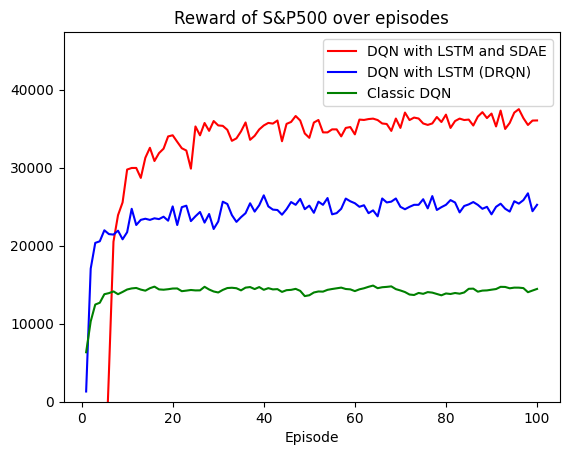

In [ ]:
from IPython.core.prefilter import PrefilterError
import matplotlib.pyplot as plt
cfg = Config()
# Graph the training result of SP500

plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_SP, color='red', label='DQN with LSTM and SDAE')
plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_SP_X, color='blue', label='DQN with LSTM (DRQN)')
plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_SP_XX, color='green', label='Classic DQN')
plt.legend()
plt.ylim(0,)
plt.title('Reward of S&P500 over episodes')
plt.xlabel('Episode')
plt.show()

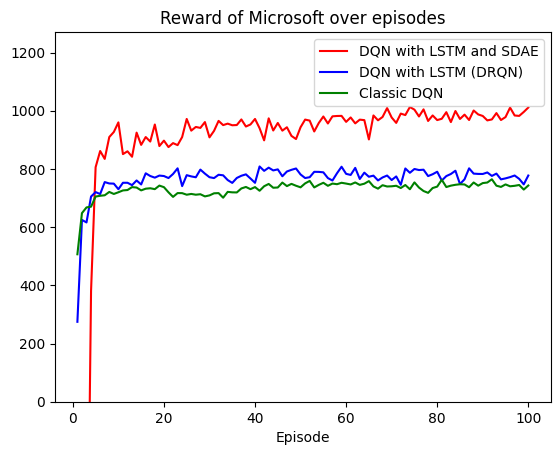

In [ ]:
plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_MSFT, color='red', label='DQN with LSTM and SDAE')
plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_MSFT_X, color='blue', label='DQN with LSTM (DRQN)')
plt.plot(list(range(1, cfg.train_eps+1)), rewards_train_MSFT_XX, color='green', label='Classic DQN')
plt.legend()
plt.title('Reward of Microsoft over episodes')
plt.xlabel('Episode')
plt.ylim(0,)
plt.show()

Text(0.5, 0, 'Episode')

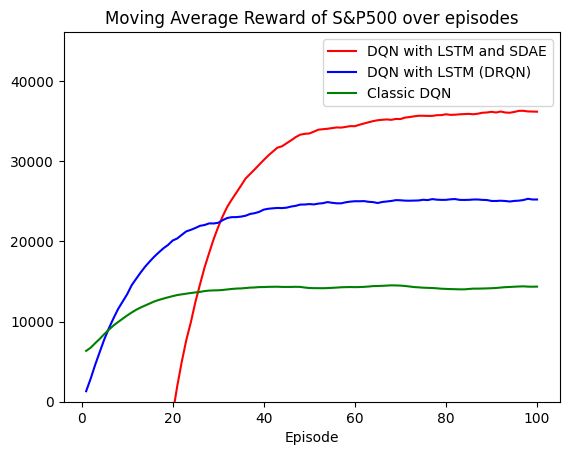

In [ ]:
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_SP, color='red', label='DQN with LSTM and SDAE')
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_SP_X, color='blue', label='DQN with LSTM (DRQN)')
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_SP_XX, color='green', label='Classic DQN')
plt.legend()
plt.ylim(0,)
plt.title('Moving Average Reward of S&P500 over episodes')
plt.xlabel('Episode')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Episode')

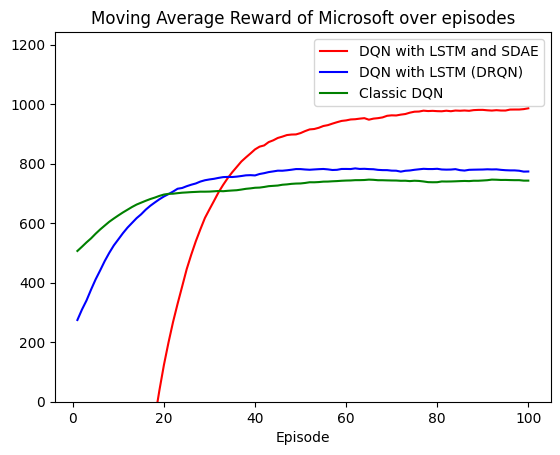

In [ ]:
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_MSFT, color='red', label='DQN with LSTM and SDAE')
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_MSFT_X, color='blue', label='DQN with LSTM (DRQN)')
plt.plot(list(range(1, cfg.train_eps+1)), ma_rewards_train_MSFT_XX, color='green', label='Classic DQN')
plt.legend()
plt.ylim(0,)
plt.title('Moving Average Reward of Microsoft over episodes')
plt.xlabel('Episode')

In [ ]:
corr_SP = corr_SP.iloc[:,1].values.tolist()
corr_MSFT = corr_MSFT.iloc[:,1].values.tolist()

In [ ]:
# -1 to -0.9
corr_SP_1 = []
for i in corr_SP:
    if i >=-1 and i <=-0.9:
        corr_SP_1.append(i)
corr_MSFT_1 = []
for i in corr_MSFT:
    if i >=-1 and i <-0.9:
        corr_MSFT_1.append(i)
# -0.9 to -0.7
corr_SP_2 = []
for i in corr_SP:
    if i >=-0.9 and i <-0.7:
        corr_SP_2.append(i)
corr_MSFT_2 = []
for i in corr_MSFT:
    if i >=-0.9 and i <-0.7:
        corr_MSFT_2.append(i)
# -0.7 to -0.5
corr_SP_3 = []
for i in corr_SP:
    if i >=-0.7 and i <-0.5:
        corr_SP_3.append(i)
corr_MSFT_3 = []
for i in corr_MSFT:
    if i >=-0.7 and i <-0.5:
        corr_MSFT_3.append(i)
# -0.5 to -0.3
corr_SP_4 = []
for i in corr_SP:
    if i >=-0.5 and i <-0.3:
        corr_SP_4.append(i)
corr_MSFT_4 = []
for i in corr_MSFT:
    if i >=-0.5 and i <-0.3:
        corr_MSFT_4.append(i)
# -0.3 to 0
corr_SP_5 = []
for i in corr_SP:
    if i >=-0.3 and i <0:
        corr_SP_5.append(i)
corr_MSFT_5 = []
for i in corr_MSFT:
    if i >=-0.3 and i <0:
        corr_MSFT_5.append(i)

# 0 to 0.3
corr_SP_6 = []
for i in corr_SP:
    if i >=0 and i <0.3:
        corr_SP_6.append(i)
corr_MSFT_6 = []
for i in corr_MSFT:
    if i >=0 and i <0.3:
        corr_MSFT_6.append(i)

# 0.3 to 0.5
corr_SP_7 = []
for i in corr_SP:
    if i >=0.3 and i <0.5:
        corr_SP_7.append(i)
corr_MSFT_7 = []
for i in corr_MSFT:
    if i >=0.3 and i <0.5:
        corr_MSFT_7.append(i)

# 0.5 to 0.7
corr_SP_8 = []
for i in corr_SP:
    if i >=0.5 and i <0.7:
        corr_SP_8.append(i)
corr_MSFT_8 = []
for i in corr_MSFT:
    if i >=0.5 and i <0.7:
        corr_MSFT_8.append(i)

# 0.7 to 0.9
corr_SP_9 = []
for i in corr_SP:
    if i >=0.7 and i <0.9:
        corr_SP_9.append(i)
corr_MSFT_9 = []
for i in corr_MSFT:
    if i >=0.7 and i <0.9:
        corr_MSFT_9.append(i)

# 0.9 to 1
corr_SP_10 = []
for i in corr_SP:
    if i >=0.9 and i <=1:
        corr_SP_10.append(i)
corr_MSFT_10 = []
for i in corr_MSFT:
    if i >=0.9 and i <=1:
        corr_MSFT_10.append(i)

Text(0.5, 1.0, 'Number of correlation of input state and output state for S&P 500')

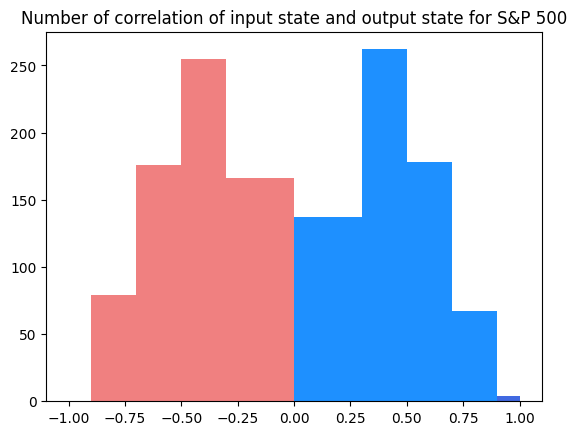

In [ ]:
plt.bar(-0.95, len(corr_SP_1), width=0.1, color='indianred', label=r'$-1\leq corr < -0.9$')
plt.bar(-0.8, len(corr_SP_2), width=0.2, color='lightcoral', label=r'$-0.9\leq corr < -0.7$')
plt.bar(-0.6, len(corr_SP_3), width=0.2, color='lightcoral', label=r'$-0.7\leq corr < -0.5$')
plt.bar(-0.4, len(corr_SP_4), width=0.2, color='lightcoral', label=r'$-0.5\leq corr < -0.3$')
plt.bar(-0.15, len(corr_SP_5), width=0.3, color='lightcoral', label=r'$-0.3\leq corr < 0$')
plt.bar(0.15, len(corr_SP_6), width=0.3, color='dodgerblue', label=r'$0\leq corr < 0.3$')
plt.bar(0.4, len(corr_SP_7), width=0.2, color='dodgerblue', label=r'$0.3 \leq corr < 0.5$')
plt.bar(0.6, len(corr_SP_8), width=0.2, color='dodgerblue', label=r'$0.5 \leq corr < 0.7$')
plt.bar(0.8, len(corr_SP_9), width=0.2, color='dodgerblue', label=r'$0.7 \leq corr < 0.9$')
plt.bar(0.95, len(corr_SP_10), width=0.1, color='royalblue', label=r'$0.9 \leq corr \leq 1$')

plt.title("Number of correlation of input state and output state for S&P 500")

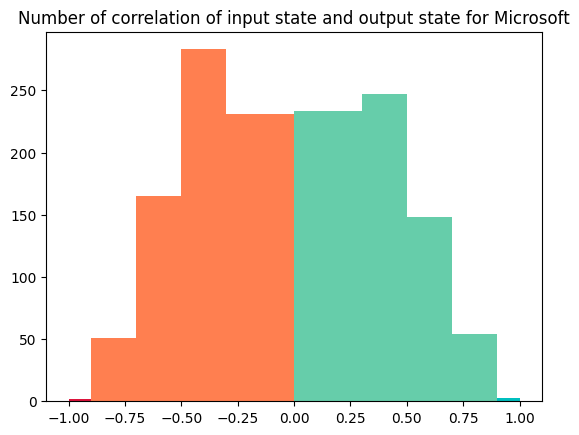

In [ ]:
plt.bar(-0.95, len(corr_MSFT_1), width=0.1, color='crimson', label=r'$-1\leq corr < -0.9$')
plt.bar(-0.8, len(corr_MSFT_2), width=0.2, color='coral', label=r'$-0.9\leq corr < -0.7$')
plt.bar(-0.6, len(corr_MSFT_3), width=0.2, color='coral', label=r'$-0.7\leq corr < -0.5$')
plt.bar(-0.4, len(corr_MSFT_4), width=0.2, color='coral', label=r'$-0.5\leq corr < -0.3$')
plt.bar(-0.15, len(corr_MSFT_5), width=0.3, color='coral', label=r'$-0.3\leq corr < 0$')
plt.bar(0.15, len(corr_MSFT_6), width=0.3, color='mediumaquamarine', label=r'$0\leq corr < 0.3$')
plt.bar(0.4, len(corr_MSFT_7), width=0.2, color='mediumaquamarine', label=r'$0.3 \leq corr < 0.5$')
plt.bar(0.6, len(corr_MSFT_8), width=0.2, color='mediumaquamarine', label=r'$0.5 \leq corr < 0.7$')
plt.bar(0.8, len(corr_MSFT_9), width=0.2, color='mediumaquamarine', label=r'$0.7 \leq corr < 0.9$')
plt.bar(0.95, len(corr_MSFT_10), width=0.1, color='c', label=r'$0.9 \leq corr \leq 1$')

plt.title("Number of correlation of input state and output state for Microsoft")
plt.show()